# Fill Model Training & Testing

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_dir = pathlib.Path("./training_sets/group2/fill")


In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 88 files belonging to 3 classes.
Using 71 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 88 files belonging to 3 classes.
Using 17 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['hollow', 'shaded', 'solid']


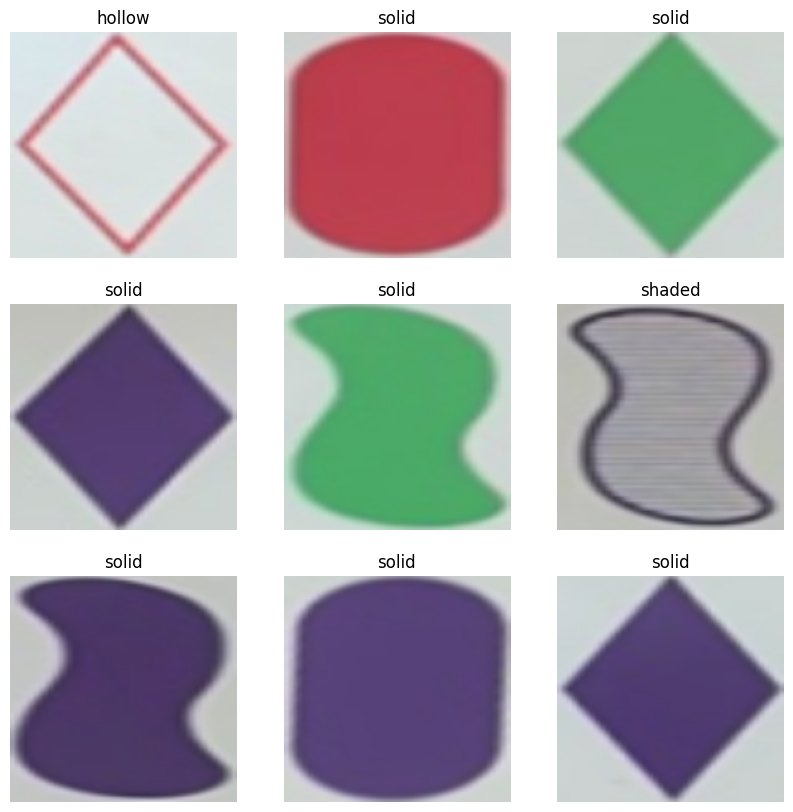

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.3072439 0.89810735


# Create the model

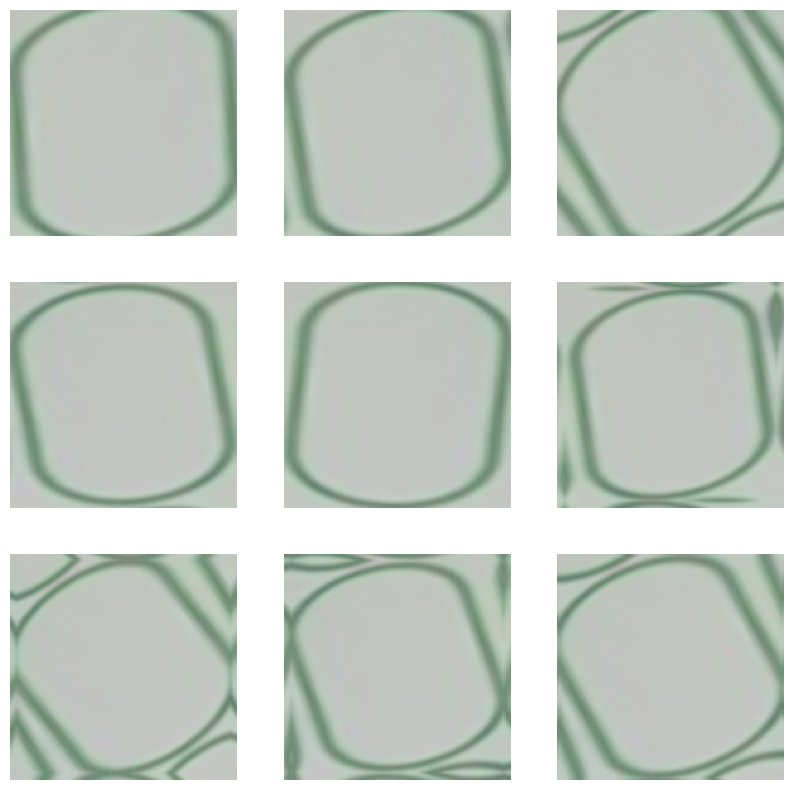

In [13]:
# Data Augmentation 

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [14]:
# Create the model

num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [15]:
# Compile it.

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [17]:
# Train it.

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


3/3 [==============================] - 1s 119ms/step - loss: 2.2471 - accuracy: 0.3380 - val_loss: 0.9624 - val_accuracy: 0.4706
Epoch 2/15
3/3 [==============================] - 0s 124ms/step - loss: 1.1522 - accuracy: 0.3239 - val_loss: 1.0738 - val_accuracy: 0.4706
Epoch 3/15
3/3 [==============================] - 0s 84ms/step - loss: 1.0674 - accuracy: 0.3239 - val_loss: 1.0276 - val_accuracy: 0.3529
Epoch 4/15
3/3 [==============================] - 0s 122ms/step - loss: 0.9987 - accuracy: 0.4507 - val_loss: 0.9594 - val_accuracy: 0.3529
Epoch 5/15
3/3 [==============================] - 0s 82ms/step - loss: 0.9467 - accuracy: 0.4648 - val_loss: 0.9122 - val_accuracy: 0.3529
Epoch 6/15
3/3 [==============================] - 0s 122ms/step - loss: 0.8973 - accuracy: 0.4507 - val_loss: 0.8306 - val_accuracy: 0.7059
Epoch 7/15
3/3 [==============================] - 0s 96ms/step - loss: 0.8648 - accuracy: 0.5634 - val_loss: 0.8917 - val_accuracy: 0.3529
Epoch 8/15
3/3 [==================

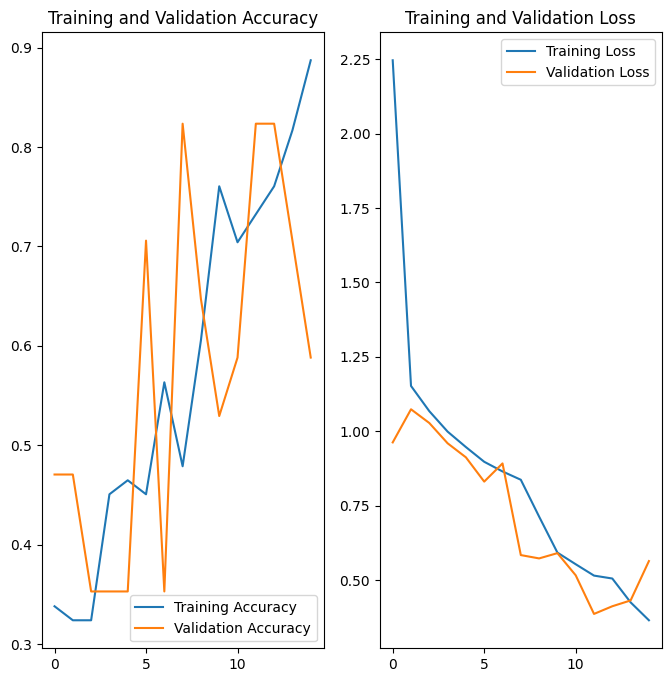

In [18]:
# Display results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
# Predicting new data


unseen_dir = pathlib.Path("./training_sets/unseen-cards/card_1_7.png")

img = tf.keras.utils.load_img(
    unseen_dir, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 61ms/step
This image most likely belongs to shaded with a 68.22 percent confidence.


In [22]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('fill_model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/_t/n4kvyq1d29x5wsk8s1grbhth0000gn/T/tmpe_d7pq1c/assets


INFO:tensorflow:Assets written to: /var/folders/_t/n4kvyq1d29x5wsk8s1grbhth0000gn/T/tmpe_d7pq1c/assets
2024-06-22 19:36:38.809629: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-06-22 19:36:38.809647: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-06-22 19:36:38.809824: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/_t/n4kvyq1d29x5wsk8s1grbhth0000gn/T/tmpe_d7pq1c
2024-06-22 19:36:38.811498: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-06-22 19:36:38.811504: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/_t/n4kvyq1d29x5wsk8s1grbhth0000gn/T/tmpe_d7pq1c
2024-06-22 19:36:38.816292: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-06-22 19:36:38.912384: I tensorflow/cc/saved_model/loader.cc:217] Running initialization

In [24]:
# Try load and use the model

TF_MODEL_FILE_PATH = 'fill_model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In [26]:
classify_lite = interpreter.get_signature_runner('serving_default')

In [30]:
print(classify_lite)

predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [31]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to shaded with a 68.22 percent confidence.
